In [118]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [119]:
homeowners_price = pd.read_csv('./data/PCU9241269241262.csv')
const_materials_price = pd.read_csv('./data/WPUSI012011.csv')
home_price_index = pd.read_csv('./data/CSUSHPISA.csv')
mortage_rate = pd.read_csv('./data/MORTGAGE30US.csv')
cpi = pd.read_csv('./data/CPIAUCSL.csv')
cpi_housing = pd.read_csv('./data/CPIHOSSL.csv')
cpi_less_food_energy = pd.read_csv('./data/CPILFESL.csv')

# Convert observation_date to datetime for all dataframes
homeowners_price['observation_date'] = pd.to_datetime(homeowners_price['observation_date'])
const_materials_price['observation_date'] = pd.to_datetime(const_materials_price['observation_date'])
home_price_index['observation_date'] = pd.to_datetime(home_price_index['observation_date'])
mortage_rate['observation_date'] = pd.to_datetime(mortage_rate['observation_date'])
cpi['observation_date'] = pd.to_datetime(cpi['observation_date'])
cpi_housing['observation_date'] = pd.to_datetime(cpi_housing['observation_date'])
cpi_less_food_energy['observation_date'] = pd.to_datetime(cpi_less_food_energy['observation_date'])

In [120]:
def merge_dataframes_on_date(left_df, right_df, date_col='observation_date'):
    merged_df = pd.merge_asof(left_df, right_df, on=date_col, direction='nearest')
    return merged_df

In [121]:
# Merge all dataframes
df = merge_dataframes_on_date(homeowners_price, const_materials_price)
df = merge_dataframes_on_date(df, home_price_index)
df = merge_dataframes_on_date(df, mortage_rate)
df = merge_dataframes_on_date(df, cpi)
df = merge_dataframes_on_date(df, cpi_housing)
df = merge_dataframes_on_date(df, cpi_less_food_energy)

print(f"Merged dataset shape: {df.shape}")
print(f"Missing values:")
print(df.isnull().sum())

Merged dataset shape: (328, 8)
Missing values:
observation_date    0
PCU9241269241262    0
WPUSI012011         0
CSUSHPISA           0
MORTGAGE30US        0
CPIAUCSL            0
CPIHOSSL            0
CPILFESL            0
dtype: int64


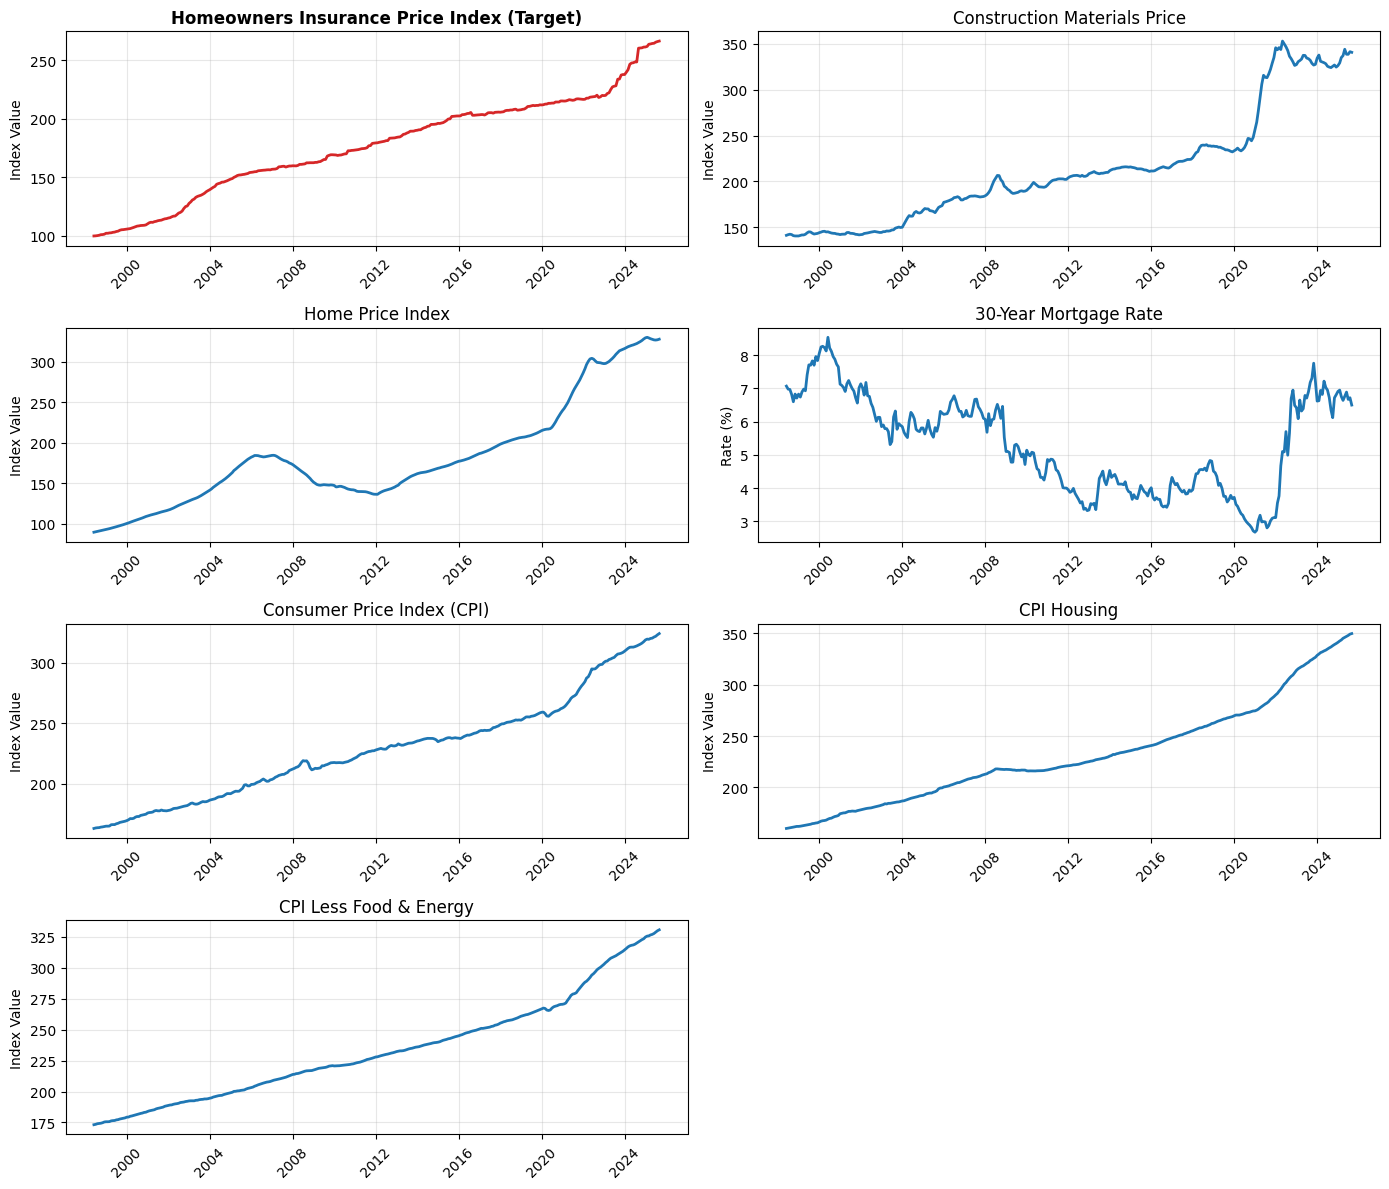

In [122]:
# Create subplots for all datasets
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
#fig.suptitle('All Data Sources Over Time', fontsize=16, y=0.995)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot target variable (Homeowners Insurance) df red
axes[0].plot(df['observation_date'], df['PCU9241269241262'],
             color='tab:red', linewidth=2)
axes[0].set_title('Homeowners Insurance Price Index (Target)', fontweight='bold')
axes[0].set_ylabel('Index Value')
axes[0].grid(alpha=0.3)

# Plot feature variables in blue
axes[1].plot(df['observation_date'], df['WPUSI012011'],
             color='tab:blue', linewidth=2)
axes[1].set_title('Construction Materials Price')
axes[1].set_ylabel('Index Value')
axes[1].grid(alpha=0.3)

axes[2].plot(df['observation_date'], df['CSUSHPISA'],
             color='tab:blue', linewidth=2)
axes[2].set_title('Home Price Index')
axes[2].set_ylabel('Index Value')
axes[2].grid(alpha=0.3)

axes[3].plot(df['observation_date'], df['MORTGAGE30US'],
             color='tab:blue', linewidth=2)
axes[3].set_title('30-Year Mortgage Rate')
axes[3].set_ylabel('Rate (%)')
axes[3].grid(alpha=0.3)

axes[4].plot(df['observation_date'], df['CPIAUCSL'],
             color='tab:blue', linewidth=2)
axes[4].set_title('Consumer Price Index (CPI)')
axes[4].set_ylabel('Index Value')
axes[4].grid(alpha=0.3)

axes[5].plot(df['observation_date'], df['CPIHOSSL'],
             color='tab:blue', linewidth=2)
axes[5].set_title('CPI Housing')
axes[5].set_ylabel('Index Value')
axes[5].grid(alpha=0.3)

axes[6].plot(df['observation_date'], df['CPILFESL'],
             color='tab:blue', linewidth=2)
axes[6].set_title('CPI Less Food & Energy')
axes[6].set_ylabel('Index Value')
axes[6].grid(alpha=0.3)

# Hide the last unused subplot
axes[7].axis('off')

# Rotate x-axis labels for better readability
for ax in axes[:7]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [123]:
# Features
X = df[['WPUSI012011', 'CSUSHPISA', 'MORTGAGE30US', 'CPIAUCSL',
        'CPIHOSSL', 'CPILFESL']]
# Target
y = df['PCU9241269241262']

In [124]:
# Split data into training and testing sets
random_seed = 3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, shuffle=False  # shuffle=False to maintain time order
)

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=75,        # Number of boosting rounds
    max_depth=2,             # Maximum tree depth
    learning_rate=0.02,       # Step size shrinkage
    random_state=random_seed,
)

# Train the model
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [126]:
# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Model Performance:
Train RMSE: 13.7323
Test RMSE: 46.3123
Train MAE: 11.2682
Test MAE: 42.4011
Train R²: 0.8430
Test R²: -5.1816


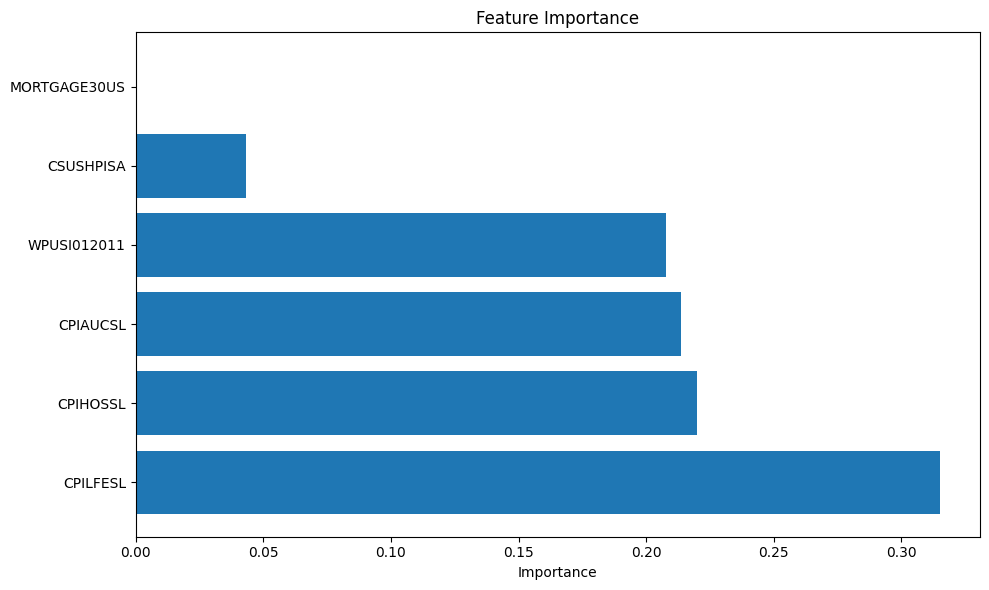

In [127]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

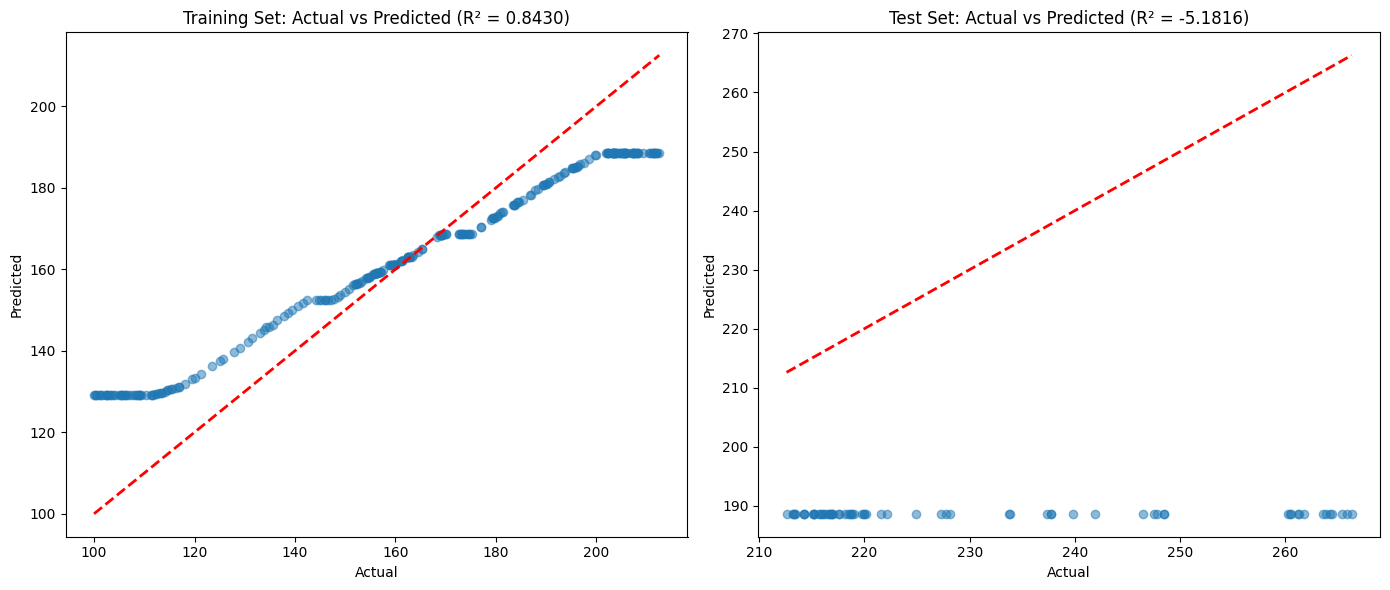

In [128]:
# Predictions vs actual values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Training Set: Actual vs Predicted (R² = {train_r2:.4f})')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})')

plt.tight_layout()
plt.show()